# Analyzing wind and stress measurements from IRGASON -- comparing two experiments on 11/21 and 12/03 for reproducibility

## Experiment parameters

* Dates: 2019-11-21 and 2019-12-03
* Tank: SUSTAIN
* Start times: 16:10 and 17:30 UTC
* Wind only, no paddle
* Fan from 0 to 60 Hz in 5 Hz intervals, each run 600 s (10 minutes)
* Fresh water
* Mean water depth: 0.8 m

**Note: Experiment on 2019-12-03 stopped, last run being 50 Hz.**

## Loading the data

In [1]:
from datetime import datetime, timedelta
import glob
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
from scipy.signal import detrend
from sustain_drag_2020.irgason import read_irgason_from_toa5, eddy_covariance_flux
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_stress_from_irgason(irgason_files, start_time, fan):
    """Returns mean wind speed and stress directly from IRGASON TOA5 files."""
    time, irg1, irg2 = read_irgason_from_toa5(irgason_files)
    
    t0 = [start_time + timedelta(seconds=n * run_seconds + 60)
        for n in range(len(fan))]
    t1 = [start_time + timedelta(seconds=(n + 1) * run_seconds)
        for n in range(len(fan))]
    
    U1, Ustd1, Wstd1, uw1 = eddy_covariance_flux(irg1, time, t0, t1, fan)
    U2, Ustd2, Wstd2, uw2 = eddy_covariance_flux(irg2, time, t0, t1, fan)
    
    return U1, uw1, U2, uw2

In [3]:
# experiment parameters
fan = range(0, 65, 5)
run_seconds = 600

In [4]:
# Experiment 2019-11-21
DATAPATH = '/home/milan/Work/sustain/data/sustain-nsf-2019/20191121'
irgason_files = glob.glob(DATAPATH + '/TOA5_SUSTAIN_Wind.FAST*.dat')
start_time = datetime(2019, 11, 21, 16, 10)
exp1 = {}
exp1['U1'], exp1['uw1'], exp1['U2'], exp1['uw2'] = get_stress_from_irgason(irgason_files, start_time, fan)

# exclude 0 Hz data and some questionable data in high winds
exp1['uw1'][0] = np.nan
exp1['uw2'][0] = np.nan
exp1['uw2'][-4:] = np.nan
exp1['uw2'][-3:] = np.nan

# Experiment 2019-12-03
DATAPATH = '/home/milan/Work/sustain/data/sustain-nsf-2019/20191203'
irgason_files = glob.glob(DATAPATH + '/TOA5_SUSTAIN_Wind.FAST*.dat')
start_time = datetime(2019, 12, 3, 17, 30)
exp2 = {}
exp2['U1'], exp2['uw1'], exp2['U2'], exp2['uw2'] = get_stress_from_irgason(irgason_files, start_time, fan)

# exclude 0 Hz data and some questionable data in high winds
exp2['uw1'][0] = np.nan
exp2['uw2'][0] = np.nan
exp2['uw1'][-1:] = np.nan
exp2['uw2'][-3:] = np.nan

exp2['U1'][-2:] = np.nan
exp2['U2'][-2:] = np.nan

Reading  TOA5_SUSTAIN_Wind.FAST_635_2019_11_21_1600.dat
Reading  TOA5_SUSTAIN_Wind.FAST_636_2019_11_21_1700.dat
Reading  TOA5_SUSTAIN_Wind.FAST_637_2019_11_21_1800.dat
Processing IRGASON time series..
Reading  TOA5_SUSTAIN_Wind.FAST_757_2019_12_03_1700.dat
Reading  TOA5_SUSTAIN_Wind.FAST_759_2019_12_03_1900.dat
Reading  TOA5_SUSTAIN_Wind.FAST_758_2019_12_03_1800.dat
Processing IRGASON time series..


In [5]:
# load data from ASIST
ASIST_DATA = '/home/milan/Work/sustain/data/asist-nsf-2018/nsf-drag-2018_asist-windonly-fresh.nc'
with Dataset(ASIST_DATA) as nc:
    U_irg_asist = nc.variables['U_irgason'][:]
    uw_irg_asist = nc.variables['uw_irgason'][:]
    U_hotwire_asist = nc.variables['U_hotwire'][:]
    uw_hotwire_asist = nc.variables['uw_hotwire'][:]

Text(0.5, 1.0, 'Mean wind speed vs. fan')

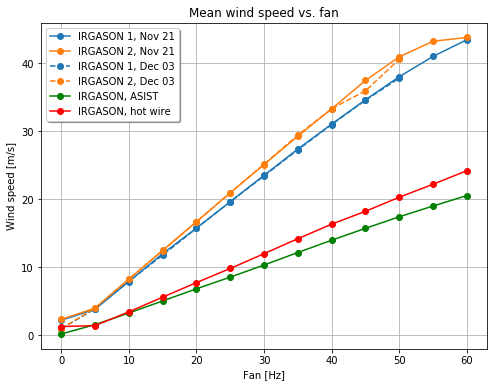

In [6]:
fig = plt.figure(figsize=(8, 6))
plt.plot(fan, exp1['U1'], linestyle='-', color='tab:blue', marker='o', label='IRGASON 1, Nov 21')
plt.plot(fan, exp1['U2'], linestyle='-', color='tab:orange', marker='o', label='IRGASON 2, Nov 21')
plt.plot(fan, exp2['U1'], linestyle='--', color='tab:blue', marker='o', label='IRGASON 1, Dec 03')
plt.plot(fan, exp2['U2'], linestyle='--', color='tab:orange', marker='o', label='IRGASON 2, Dec 03')
plt.plot(fan, U_irg_asist, linestyle='-', color='g', marker='o', label='IRGASON, ASIST')
plt.plot(fan, U_hotwire_asist, linestyle='-', color='r', marker='o', label='IRGASON, hot wire')
plt.legend(loc='upper left', fancybox=True, shadow=True)
plt.grid()
plt.xlabel('Fan [Hz]')
plt.ylabel('Wind speed [m/s]')
plt.title('Mean wind speed vs. fan')

Text(0.5, 1.0, 'Stress vs. mean wind speed')

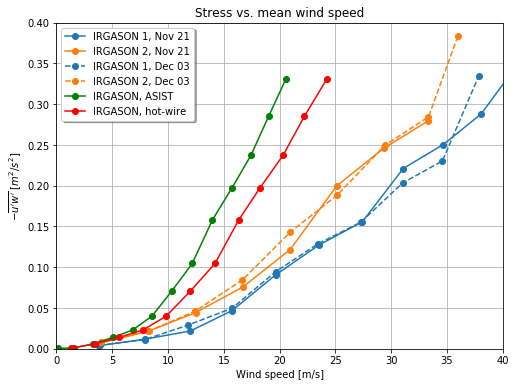

In [7]:
fig = plt.figure(figsize=(8, 6))
plt.plot(exp1['U1'], exp1['uw1'], linestyle='-', color='tab:blue', marker='o', label='IRGASON 1, Nov 21')
plt.plot(exp1['U2'], exp1['uw2'], linestyle='-', color='tab:orange', marker='o', label='IRGASON 2, Nov 21')
plt.plot(exp2['U1'], exp2['uw1'], linestyle='--', color='tab:blue', marker='o', label='IRGASON 1, Dec 03')
plt.plot(exp2['U2'], exp2['uw2'], linestyle='--', color='tab:orange', marker='o', label='IRGASON 2, Dec 03')
plt.plot(U_irg_asist, -uw_irg_asist, linestyle='-', color='g', marker='o', label='IRGASON, ASIST')
plt.plot(U_hotwire_asist, -uw_hotwire_asist, linestyle='-', color='r', marker='o', label='IRGASON, hot-wire')
plt.legend(loc='upper left', fancybox=True, shadow=True)
plt.grid()
plt.xlim(0, 40)
plt.ylim(0, 0.4)
plt.xlabel('Wind speed [m/s]')
plt.ylabel(r"$-\overline{u'w'}$ [$m^2/s^2$]")
plt.title('Stress vs. mean wind speed')

Notes:

* IRGASON height in SUSTAIN is about 0.6 m
* IRGASON and hot-wire heights in ASIST is 0.29 m